In [1]:
# basic dependencies
from pathlib import Path
if Path.cwd().parent.stem == 't3':
    %cd ..

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/compVision-DCC/t3
    
    assert torch.__version__.startswith("1.8")   
    try: 
        import detectron2
    except ImportError:
        !pip install pyyaml>=5.1
        !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
else:
    %config Completer.use_jedi = False

/workspace/compVision-DCC/t3
1.7.1 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# Train on a custom dataset

## Prepare the dataset

Register the dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [4]:
from pathlib import Path
from detectron2.structures import BoxMode

def get_mnist_dict(base_dir: str):
    base_dir = Path(base_dir)
    img_dir = Path(base_dir) / "images"
    annot_dir = Path(base_dir) / "labels"

    dataset_dicts = []
    for idx, annot_f in enumerate(annot_dir.iterdir()):
        
        # print(annot)
        filename = annot_f.stem + '.png'
        filename = img_dir / filename

        if not filename.exists():
            continue
            
        height, width = cv2.imread(str(filename)).shape[:2]

        with open(annot_f) as f:
            img_annots = f.readlines()[1:]

        record = {}
        record["file_name"] = str(filename)
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for annot in img_annots:
            # example: 4,83,8,43,53
            
            category_bbox_str = annot.split(',')
            category_str, bbox_str = category_bbox_str[0], category_bbox_str[1:]
            
            bbox = [int(p_str.replace('\n', '').strip()) for p_str in bbox_str]
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                # "segmentation": [poly],
                "category_id": int(category_str),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
data_path = Path('data/mnist_detection_150_500')

for d in ["train", "test"]:
    DatasetCatalog.register("mnist_" + d, lambda d=d: get_mnist_dict(data_path / d))
    MetadataCatalog.get("mnist_" + d).set(thing_classes=[str(i) for i in range(10)])

mnist_metadata_test = MetadataCatalog.get("mnist_test")
mnist_metadata = MetadataCatalog.get("mnist_train")

In [7]:
from detectron2.data.datasets.coco import register_coco_instances, convert_to_coco_dict
import json

mnist_coco_dict = convert_to_coco_dict("mnist_test")

with open('mnist_coco.json', 'w') as fp:
    json.dump(mnist_coco_dict, fp)
    
register_coco_instances("mnist-test", {}, "mnist_coco.json", "")

[06/13 22:07:39 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/13 22:07:39 d2.data.datasets.coco]: Conversion finished, #images: 1000, #annotations: 5482


{'file_name': 'data/mnist_detection_150_500/train/images/5120.png', 'image_id': 1960, 'height': 150, 'width': 500, 'annotations': [{'bbox': [292, 75, 322, 113], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3}, {'bbox': [72, 39, 112, 86], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 7}, {'bbox': [216, 12, 263, 67], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2}, {'bbox': [66, 82, 83, 101], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 8}]}


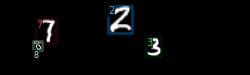

In [8]:
dataset_dicts = get_mnist_dict(data_path / "train")
for d in random.sample(dataset_dicts,1):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mnist_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    showarray(out.get_image())

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [9]:
from detectron2.engine import DefaultTrainer

from utils.MyTrainer import MyTrainer
from CenterNet2.centernet.config import add_centernet_config
from CenterNet2.train_net import do_train, do_test

cfg = get_cfg()
add_centernet_config(cfg)

cfg.merge_from_file('CenterNet2/configs/CenterNet-S4_DLA_8x.yaml')
cfg.DATASETS.TRAIN = ("mnist_train",)
cfg.DATASETS.TEST = ("mnist-test",)
cfg.TEST.EVAL_PERIOD = 250
cfg.DATALOADER.NUM_WORKERS = 9
cfg.MODEL.WEIGHTS = '/workspace/compVision-DCC/t3/CenterNet2/CenterNet-S4_DLA_8x.pth'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00020  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset

cfg.SOLVER.STEPS = []        # do not decay learning rate

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = MyTrainer(cfg) 
#trainer.resume_or_load(resume=False)

cfg = setup(args)
model = build_model(cfg)

do_train(cfg, model, resume=False)

res = do_test(cfg, model)

ModuleNotFoundError: No module named 'centernet'

In [6]:
!zip -r notebooks.zip notebooks

updating: notebooks/ (stored 0%)
  adding: notebooks/Detectron2_Tutorial.ipynb (deflated 53%)
  adding: notebooks/Detectron2_checks_TridentNet.ipynb (deflated 74%)
  adding: notebooks/Detectron2_mnist.ipynb (deflated 71%)
  adding: notebooks/auxiliar_05.ipynb (deflated 75%)
  adding: notebooks/input.jpg (deflated 0%)
  adding: notebooks/.ipynb_checkpoints/ (stored 0%)
  adding: notebooks/.ipynb_checkpoints/Detectron2_mnist-checkpoint.ipynb (deflated 71%)
  adding: notebooks/.ipynb_checkpoints/Detectron2_checks_TridentNet-checkpoint.ipynb (deflated 75%)
  adding: notebooks/.ipynb_checkpoints/Detectron2_mnist-centernet-checkpoint.ipynb (deflated 71%)
  adding: notebooks/.ipynb_checkpoints/Detectron2_checks_TridentNet-Copy1-checkpoint.ipynb (deflated 75%)
  adding: notebooks/Detectron2_mnist-centernet.ipynb (deflated 46%)
  adding: notebooks/Detectron2_checks_TridentNet-Copy1.ipynb (deflated 75%)


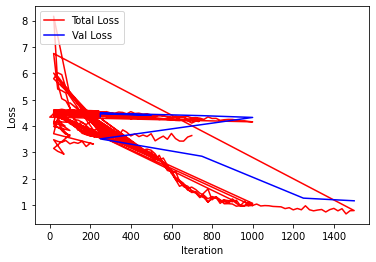

In [44]:
import json
import matplotlib.pyplot as plt

experiment_folder = 'output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')

ax1.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x],
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], color="red", label="Total Loss")

ax1.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], color="blue", label="Val Loss")
    
ax1.tick_params(axis='y')
plt.legend(loc='upper left')
plt.show()


## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [35]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

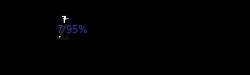

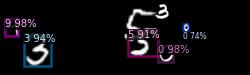

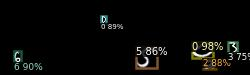

In [15]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_mnist_dict(data_path / "test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=mnist_metadata_test, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    showarray(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("mnist_test", ("bbox",), False, output_dir="./output/inference")
val_loader = build_detection_test_loader(cfg, "mnist-test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [06/13 21:28:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/13 21:28:38 d2.data.datasets.coco]: Loaded 1000 images in COCO format from mnist_coco.json
[06/13 21:28:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/13 21:28:38 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[06/13 21:28:38 d2.data.common]: Serialized dataset takes 0.51 MiB
[06/13 21:28:38 d2.evaluation.evaluator]: Start inference on 1000 images
[06/13 21:28:40 d2.evaluation.evaluator]: Inference done 11/1000. 0.1085 s / img. ETA=0:01:48
[06/13 21:28:45 d2.evaluation.evaluator]: Inference done 57/1000. 0.1083 s / img. ETA=0:01:43
[06/13 21:28:50 d2.evaluation.evaluator]: Inference done 103/1000. 0.1084 s / img. ETA=0:01:38
[06/13 21:28:55 d2.evaluation.evaluator]: Inference done 14

In [42]:
from detectron2.checkpoint import Checkpointer
ckpt = Checkpointer(trainer.model, "output")
ckpt.save("best_mnist")